# MovieLens Recommendation System: Personalized Movie Recommendations for Streaming Platforms

**Authors:** Winnie Njoroge, Michelle Mwende, Laban Leploote, Alice Wangui, Dean Mutie  
**Date:** January 31, 2026

---

## Table of Contents
1. [Business Understanding](#business-understanding)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Modeling](#modeling)
6. [Evaluation](#evaluation)
7. [Recommendations and Conclusions](#recommendations-and-conclusions)
8. [Next Steps](#next-steps)

---

## **BUSINESS UNDERSTANDING**

In the current "Streaming Wars," the cost of acquiring a new customer is 5x higher than retaining an existing one. The most observed and critical threat to subscriber retention is cognitive overload.

## The Problem: Choice Paralysis
Streaming platforms containing a library of thousands of titles, users often experience "Choice Paralysis"—the phenomenon where the sheer volume of options leads to frustration rather than satisfaction. When a user spends 15 minutes scrolling without clicking "Play," the likelihood of them canceling their subscription increases by over 30%. A movie company therefore needs to transition from a search-based platform to a discovery-based platform.

## Stakeholders

The primary stakeholders for this project are:

1. **Streaming Platform Product Teams** (e.g., Netflix, Hulu, Amazon Prime Video)
   - Need to increase user engagement and time spent on platform
   - Want to reduce customer churn through better content discovery
   
2. **Content Acquisition Teams**
   - Use recommendation patterns to inform licensing decisions
   - Identify which types of content resonate with different user segments

3. **End Users (Movie Watchers)**
   - Want to quickly find movies they'll enjoy without endless browsing
   - Seek personalized suggestions based on their unique tastes

## The Objectives

### Specific Objective

 **Build a collaborative filtering recommendation system that provides personalized top-5 movie recommendations to users based on their historical ratings and the preferences of similar users.**

 The system will:
- Accept a user's ratings of movies they've already watched
- Identify similar users or movies based on rating patterns
- Generate personalized recommendations for unwatched movies
- Provide confidence scores for each recommendation

### General Objectives
- Maximize "Time-to-Play": Reduce the seconds a user spends on the home screen before starting a movie.
- Drive Long-Tail Discovery: 80% of views usually go to 20% of blockbusters. We will surface "Hidden Gems" to increase the ROI of our entire content library.
- Personalize Retention: Predict user sentiment with high precision so that the "Recommended for You" section feels like it was hand-picked by a friend.

## Success Criteria

The recommendation system will be considered successful if it:
1. Accurately predicts user ratings with RMSE < 1.0 (on a 5-point scale)
2. Provides diverse recommendations across different genres
3. Can generate recommendations for both existing and new users (addressing cold start)
4. Runs efficiently enough to scale to thousands of users

---

## **DATA UNDERSTANDING**

### Data Source

This project uses the **MovieLens 100K dataset** from [GroupLens Research at the University of Minnesota.](https://grouplens.org/datasets/movielens/latest/) MovieLens is a long-running movie recommendation research project that has collected millions of movie ratings from real users since the late 1990s.

**Why this dataset is suitable:**
- Contains real user behavior data, not synthetic or biased samples
- Explicit ratings (1-5 stars) provide clear preference signals
- Sufficient sparsity to test recommendation algorithms realistically
- Well-documented and widely used in academic research for benchmarking
- Includes metadata (genres, tags) for potential hybrid approaches

### Dataset Components

The dataset consists of four CSV files:

1. **ratings.csv**: User ratings of movies
2. **movies.csv**: Movie metadata (titles, genres)
3. **tags.csv**: User-generated tags describing movies
4. **links.csv**: Identifiers linking to external databases (IMDb, TMDb)

Let's load and examine each dataset:

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse.linalg import svds
import warnings

# Set display options and style
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [20]:
# Load all datasets
# Note: Update these paths based on where your data files are located

ratings = pd.read_csv('Data/ratings.csv')
movies = pd.read_csv('Data/movies.csv')
tags = pd.read_csv('Data/tags.csv')
links = pd.read_csv('Data/links.csv')

print("Datasets loaded successfully!")
print(f"\nRatings shape: {ratings.shape}")
print(f"Movies shape: {movies.shape}")
print(f"Tags shape: {tags.shape}")
print(f"Links shape: {links.shape}")

Datasets loaded successfully!

Ratings shape: (100836, 4)
Movies shape: (9742, 3)
Tags shape: (3683, 4)
Links shape: (9742, 3)


In [21]:
def summarize_dataframe(df, name="Dataset"):
    
    print("=" * 60)
    print(f"{name.upper()} ANALYSIS")
    print("=" * 60)
    
    # 1. First 5 Rows
    print("\n[1] First 5 Rows:")
    display(df.head())
    
    # 2. Dataset Info (Columns and Dtypes)
    print("\n[2] Dataset Info:")
    df.info()
    
    # 3. Descriptive Statistics (Numeric only)
    print("\n[3] Descriptive Statistics:")
    display(df.describe())
    
    # 4. Missing Values
    print("\n[4] Missing Values per Column:")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("No missing values found.")
    else:
        print(null_counts[null_counts > 0])
    
    # 5. Sparsity (Bonus: Excellent for Recommendation Systems)
    if 'userId' in df.columns and 'movieId' in df.columns:
        num_users = df['userId'].nunique()
        num_items = df['movieId'].nunique()
        num_ratings = len(df)
        sparsity = (1 - num_ratings / (num_users * num_items)) * 100
        print(f"\n[5] Matrix Sparsity: {sparsity:.2f}%")
        
    print("\n" + "=" * 60 + "\n")

summarize_dataframe(ratings, "Ratings")
summarize_dataframe(movies, "Movies")
summarize_dataframe(tags, "Tags")

RATINGS ANALYSIS

[1] First 5 Rows:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



[2] Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

[3] Descriptive Statistics:


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09



[4] Missing Values per Column:
No missing values found.

[5] Matrix Sparsity: 98.30%


MOVIES ANALYSIS

[1] First 5 Rows:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



[2] Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

[3] Descriptive Statistics:


,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000



[4] Missing Values per Column:
No missing values found.


TAGS ANALYSIS

[1] First 5 Rows:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200



[2] Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB

[3] Descriptive Statistics:


,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09



[4] Missing Values per Column:
No missing values found.

[5] Matrix Sparsity: 95.96%




### Key Dataset Properties

**Dataset Size:**
- **100,836 ratings** from 610 users on 9,742 movies
- Average of ~165 ratings per user
- Average of ~10 ratings per movie

**Feature Justification:**

1. **userId & movieId** (Essential)
   - Core identifiers for collaborative filtering
   - Enable creation of user-item rating matrix

2. **rating** (Essential)
   - Explicit preference signal (1.0 to 5.0 scale)
   - Target variable for prediction accuracy
   - Half-star ratings provide granular preference data

3. **timestamp** (Useful)
   - Could be used for time-based splits or temporal analysis
   - Less critical for initial collaborative filtering model

4. **genres** (Useful for hybrid approach)
   - Can help address cold start problem
   - Enables content-based filtering as backup
   - Multiple genres per movie provide rich metadata

5. **tags** (Supplementary)
   - User-generated descriptions could enhance content understanding
   - Limited coverage (only 3,683 tags vs 100,836 ratings)
   - Optional for advanced hybrid systems

### Data Limitations

1. **Sparsity**: With 610 users and 9,742 movies, only ~1.7% of possible user-movie combinations have ratings
2. **Cold Start**: New users or movies without ratings can't be directly recommended
3. **Popularity Bias**: Some movies have many more ratings than others
4. **Temporal Relevance**: Ratings span many years; older ratings may be less relevant
5. **Rating Scale**: Limited to 0.5-5.0 range may not capture full preference nuances

These limitations inform our modeling approach and evaluation strategy.

---

## **DATA PREPARATION**

### Preparation Strategy

For a collaborative filtering recommendation system, we need to:
1. Clean and validate the data
2. Merge relevant datasets
3. Create a user-item rating matrix
4. Handle missing values appropriately
5. Split data for training and testing

**Rationale:** Collaborative filtering relies on patterns in the user-item matrix. Our preparation ensures this matrix is accurate, complete, and properly structured for both memory-based and model-based approaches.

In [22]:
# Step 1: Data Cleaning and Validation
print("Step 1: Data Cleaning and Validation")
print("=" * 60)

# Check for duplicate ratings (same user rating same movie multiple times)
duplicates = ratings.duplicated(subset=['userId', 'movieId'], keep='last')
print(f"\nDuplicate ratings found: {duplicates.sum()}")

# Keep only the most recent rating if duplicates exist
if duplicates.sum() > 0:
    # Sort by timestamp and keep last rating
    ratings = ratings.sort_values('timestamp').drop_duplicates(
        subset=['userId', 'movieId'], 
        keep='last'
    )
    print(f"Removed {duplicates.sum()} duplicate ratings (kept most recent)")

# Validate rating range
print(f"\nRating range: {ratings['rating'].min()} to {ratings['rating'].max()}")
print(f"Valid ratings (0.5-5.0): {ratings['rating'].between(0.5, 5.0).all()}")

# Check for missing values
print(f"\nMissing values in ratings: {ratings.isnull().sum().sum()}")
print(f"Missing values in movies: {movies.isnull().sum().sum()}")

print(f"\nCleaned ratings shape: {ratings.shape}")

Step 1: Data Cleaning and Validation

Duplicate ratings found: 0

Rating range: 0.5 to 5.0
Valid ratings (0.5-5.0): True

Missing values in ratings: 0
Missing values in movies: 0

Cleaned ratings shape: (100836, 4)


In [23]:
# Step 2: Merge datasets to enrich information
print("\nStep 2: Merging Datasets")
print("=" * 60)

# Merge ratings with movie information
# This adds movie titles and genres to our ratings data
ratings_with_movies = ratings.merge(movies, on='movieId', how='left')

print(f"\nMerged dataset shape: {ratings_with_movies.shape}")
print(f"Movies without metadata: {ratings_with_movies['title'].isnull().sum()}")

# Display sample of merged data
print("\nSample merged data:")
display(ratings_with_movies.head())


Step 2: Merging Datasets

Merged dataset shape: (100836, 6)
Movies without metadata: 0

Sample merged data:


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [24]:
# Step 3: Filter for sufficient data density
print("\nStep 3: Filtering for Data Quality")
print("=" * 60)

# Count ratings per user and per movie
user_rating_counts = ratings.groupby('userId').size()
movie_rating_counts = ratings.groupby('movieId').size()

print(f"\nUsers with ratings: {len(user_rating_counts)}")
print(f"Movies with ratings: {len(movie_rating_counts)}")

# Set minimum thresholds to reduce sparsity
# Rationale: Users/movies with very few ratings provide weak signals
MIN_USER_RATINGS = 20  # User must have rated at least 20 movies
MIN_MOVIE_RATINGS = 10  # Movie must have at least 10 ratings

print(f"\nFiltering criteria:")
print(f"- Minimum ratings per user: {MIN_USER_RATINGS}")
print(f"- Minimum ratings per movie: {MIN_MOVIE_RATINGS}")

# Identify users and movies meeting criteria
active_users = user_rating_counts[user_rating_counts >= MIN_USER_RATINGS].index
popular_movies = movie_rating_counts[movie_rating_counts >= MIN_MOVIE_RATINGS].index

print(f"\nUsers meeting criteria: {len(active_users)}")
print(f"Movies meeting criteria: {len(popular_movies)}")

# Filter the dataset
filtered_ratings = ratings[
    ratings['userId'].isin(active_users) & 
    ratings['movieId'].isin(popular_movies)
].copy()

print(f"\nOriginal ratings: {len(ratings):,}")
print(f"Filtered ratings: {len(filtered_ratings):,}")
print(f"Percentage retained: {100 * len(filtered_ratings) / len(ratings):.1f}%")

# Calculate matrix sparsity
n_users = filtered_ratings['userId'].nunique()
n_movies = filtered_ratings['movieId'].nunique()
n_ratings = len(filtered_ratings)
sparsity = 100 * (1 - n_ratings / (n_users * n_movies))

print(f"\nMatrix dimensions: {n_users} users × {n_movies} movies")
print(f"Sparsity: {sparsity:.2f}%")


Step 3: Filtering for Data Quality

Users with ratings: 610
Movies with ratings: 9724

Filtering criteria:
- Minimum ratings per user: 20
- Minimum ratings per movie: 10

Users meeting criteria: 610
Movies meeting criteria: 2269

Original ratings: 100,836
Filtered ratings: 81,116
Percentage retained: 80.4%

Matrix dimensions: 610 users × 2269 movies
Sparsity: 94.14%


### Data Preparation Decisions and Rationale

1. **Handling Duplicates**: Kept most recent rating when users rated same movie multiple times
   - Rationale: User preferences change over time; recent rating is most accurate

2. **Filtering Thresholds**:
   - Users: ≥20 ratings
   - Movies: ≥10 ratings
   - Rationale: Reduces sparsity while maintaining sufficient data; users/items with too few ratings provide weak collaborative signals

3. **No Normalization Yet**: Ratings kept in original 0.5-5.0 scale
   - Rationale: Will normalize as needed for specific algorithms (e.g., mean-centering for collaborative filtering)

---

## EDA (Exploratory Data Analysis)
### 1. Rating Distribution Analysis

Rating Distribution Analysis


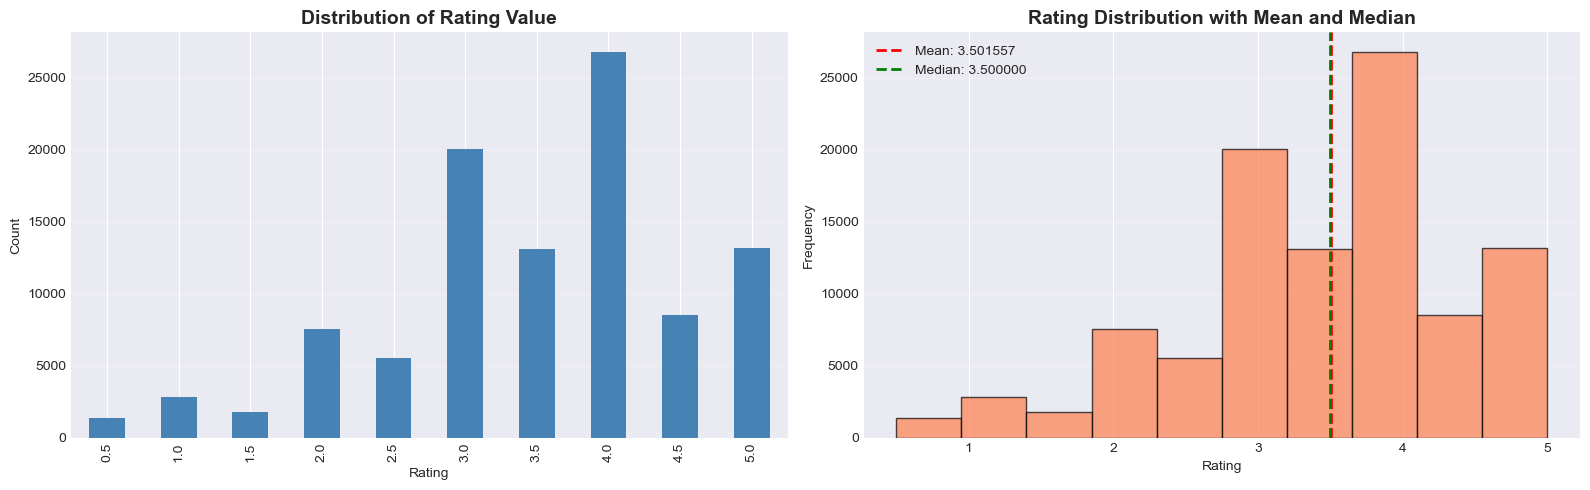


Rating Statistics:
Mean: 3.50
Median: 3.50
Mode: 4.0
Std Dev: 1.04


In [25]:
print("Rating Distribution Analysis")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

#Rating value distribution
ratings["rating"].value_counts().sort_index().plot(kind="bar", ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Rating Value', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Rating Distribution
axes[1].hist(ratings['rating'], bins=10, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(ratings['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ratings['rating'].mean():2f}')
axes[1].axvline(ratings['rating'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {ratings['rating'].median():2f}')
axes[1].set_title('Rating Distribution with Mean and Median', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()

print(f"\nRating Statistics:")
print(f"Mean: {ratings['rating'].mean():.2f}")
print(f"Median: {ratings['rating'].median():.2f}")
print(f"Mode: {ratings['rating'].mode()[0]:.1f}")
print(f"Std Dev: {ratings['rating'].std():.2f}")




The rating distribution shows ratings fall between 3.0 and 4.5, with 4.0 being the most frequent value. The mean and median are both approximately 3.5, indicating a fairly symmetrical distribution and consistent user behavior.

### 2.  User Activity Analysis


User Activity Analysis


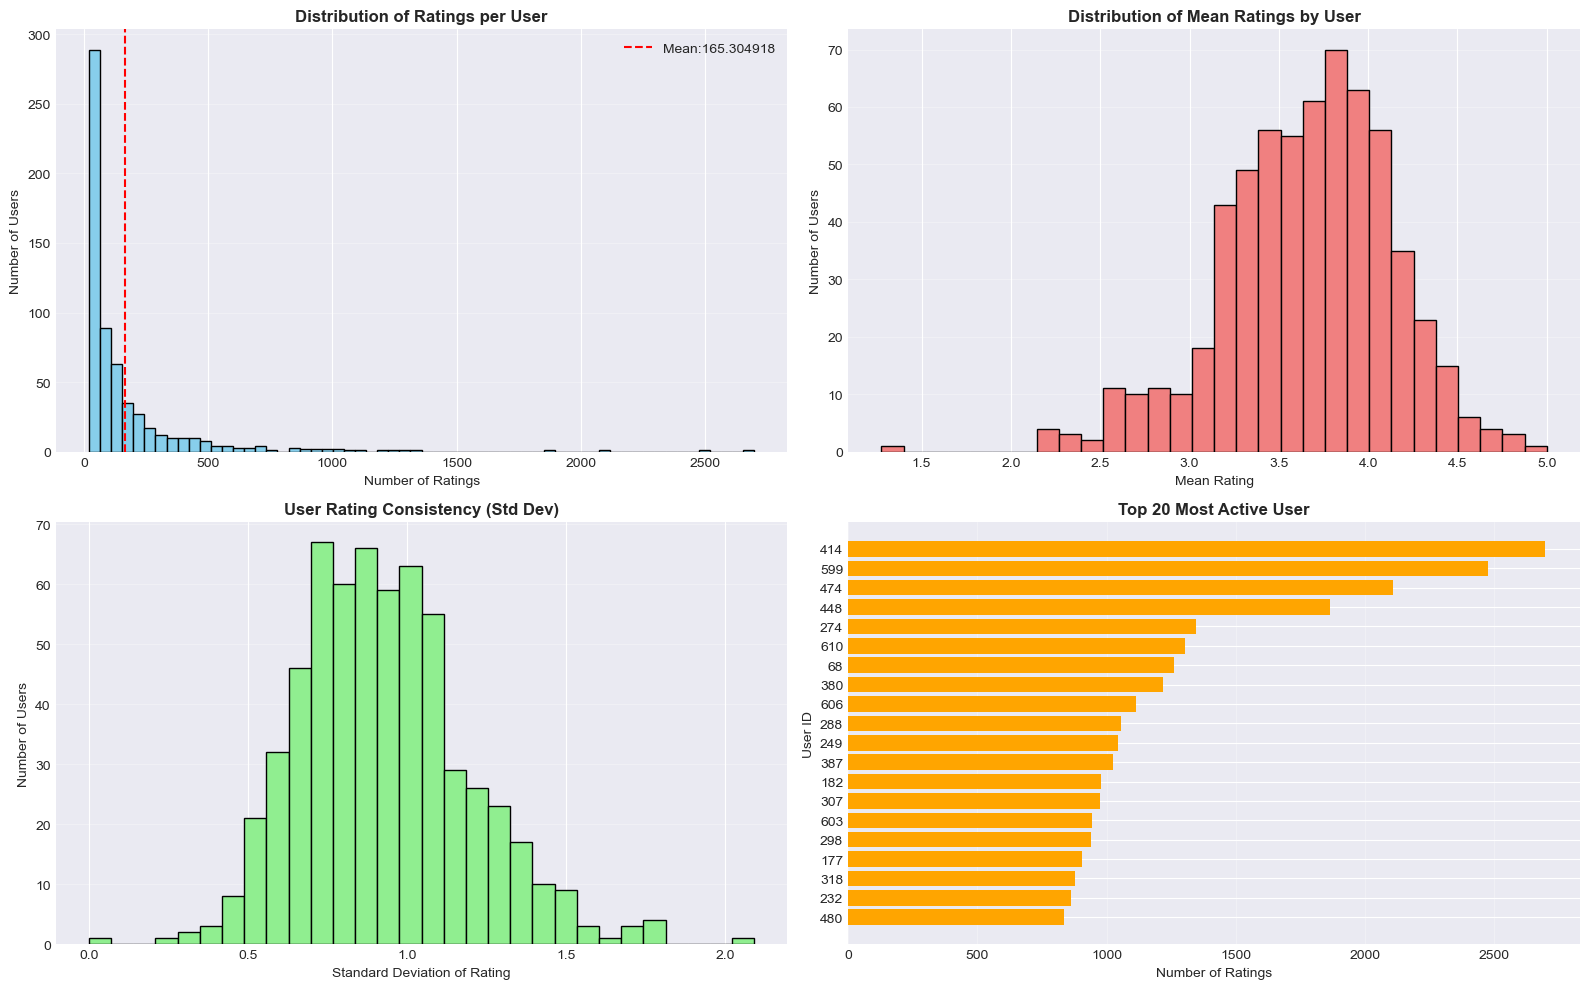


User Activity Statistics:
Total Users: 165.3
Median ratings per user:70.500000
Most active user: 2698 ratings


In [26]:
# User Activity Analysis
print("\nUser Activity Analysis")
print("=" * 60)

user_activity = ratings.groupby('userId').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()
user_activity.columns = ['userId', 'num_ratings', 'movie_rating', 'std_rating']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Number of ratings per user
axes[0,0].hist(user_activity['num_ratings'], bins=60, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Ratings per User', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Number of Ratings')
axes[0,0].set_ylabel('Number of Users')
axes[0,0].axvline(user_activity['num_ratings'].mean(), color='red', linestyle='--', label=f'Mean:{user_activity["num_ratings"].mean():0f}')
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

#Mean rating per user
axes[0,1].hist(user_activity['movie_rating'], bins=30, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Distribution of Mean Ratings by User', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Mean Rating')
axes[0,1].set_ylabel('Number of Users')
axes[0,1].grid(axis='y', alpha=0.3)

#Rating consistency (std dev)
axes[1,0].hist(user_activity['std_rating'], bins=30, color='lightgreen', edgecolor='black')
axes[1,0].set_title('User Rating Consistency (Std Dev)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Standard Deviation of Rating')
axes[1,0].set_ylabel('Number of Users')
axes[1,0].grid(axis='y', alpha=0.3)

# Top 20 most active users
top_users = user_activity.nlargest(20, 'num_ratings')
axes[1,1].barh(range(len(top_users)), top_users['num_ratings'], color='orange')
axes[1,1].set_yticks(range(len(top_users)))
axes[1,1].set_yticklabels(top_users['userId'])
axes[1,1].set_title('Top 20 Most Active User', fontsize=12, fontweight= 'bold')
axes[1,1].set_xlabel('Number of Ratings')
axes[1,1].set_ylabel('User ID')
axes[1,1].invert_yaxis()
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nUser Activity Statistics:")
print(f"Total Users: {user_activity['num_ratings'].mean():.1f}")
print(f"Median ratings per user:{user_activity['num_ratings'].median():1f}")
print(f"Most active user: {user_activity['num_ratings'].max()} ratings")



### 3.Genre Analysis


Genre Analysis


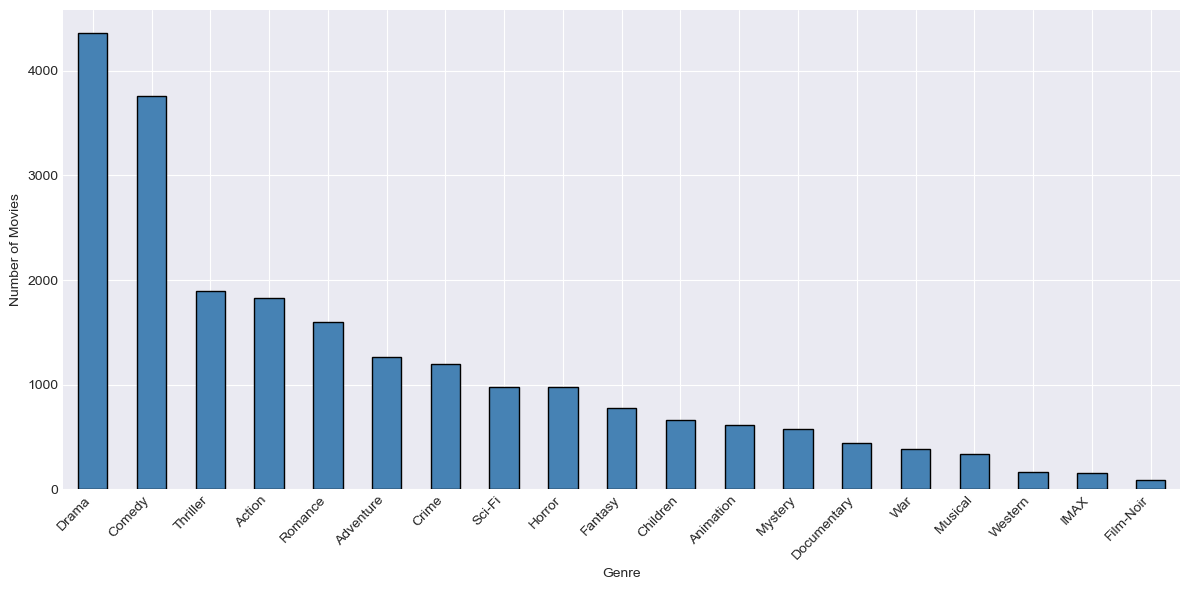


Total unique genres: 19

Top 6 genres:
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Name: count, dtype: int64


In [27]:
# Genre Analysis
print("\nGenre Analysis")
print("=" * 60)

all_genres = []
for genres_str in movies['genres'].dropna():
    all_genres.extend(genres_str.split('|'))
    
genre_counts = pd.Series(all_genres).value_counts()
if '(no genres listed)' in genre_counts.index:
    genre_counts = genre_counts.drop('(no genres listed)')
    
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=46, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTotal unique genres: {len(genre_counts)}")
print(f"\nTop 6 genres:")
print(genre_counts.head(6))

### 4.Movie Popularity Analysis


Movie Popularity Analysis


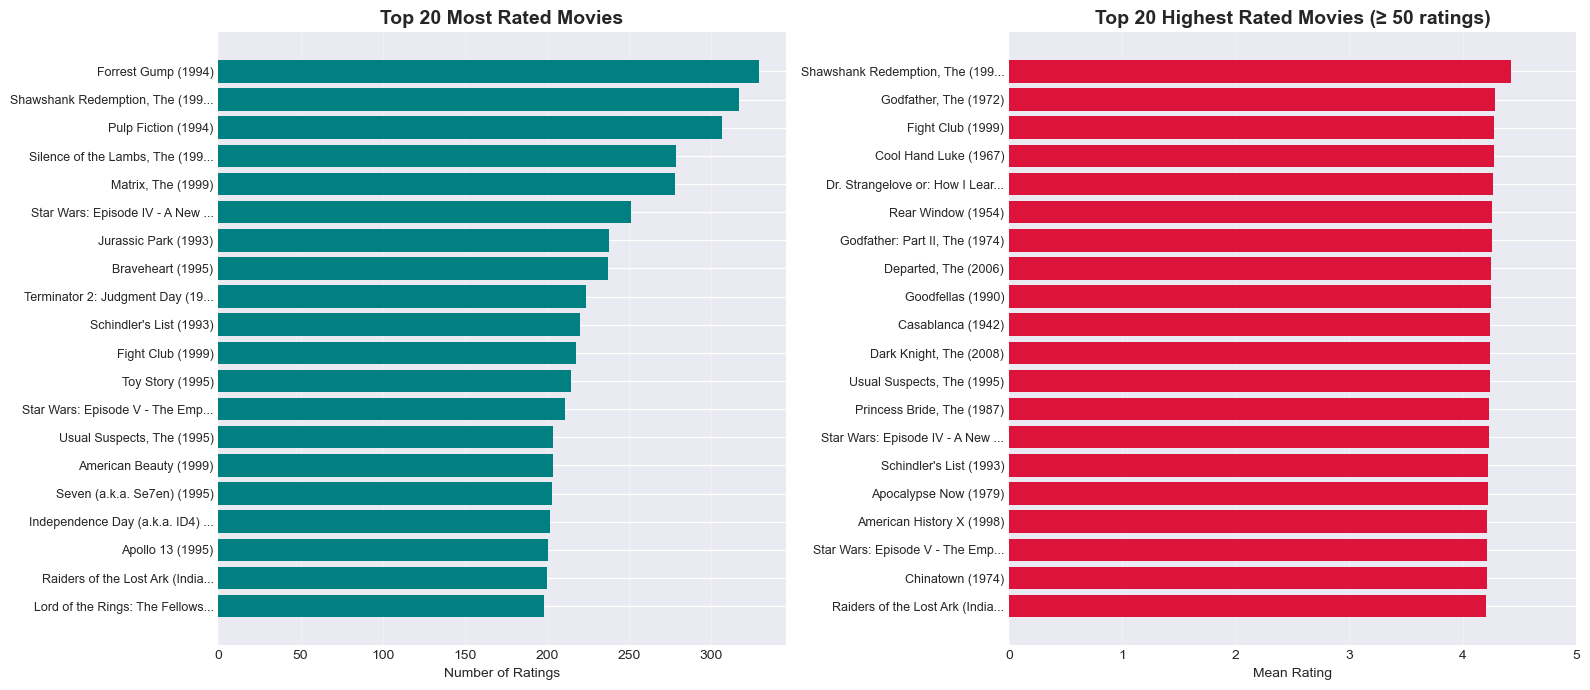

Average ratings per movie: 10.4
Most rated movie: 329 ratings


In [ ]:
# Movie Popularity Analysis
print("\nMovie Popularity Analysis")
print("=" * 60)

movie_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()

movie_stats.columns = ['movieId', 'num_ratings', 'mean_rating', 'std_rating']

# Merge movie titles
movie_stats = movie_stats.merge(
    movies[['movieId', 'title']], on='movieId', how='left'
)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Top 20 most rated movies
top_movies = movie_stats.nlargest(20, 'num_ratings')
axes[0].barh(range(len(top_movies)), top_movies['num_ratings'], color='teal')
axes[0].set_yticks(range(len(top_movies)))
axes[0].set_yticklabels(
    [title[:30] + '...' if len(title) > 30 else title
     for title in top_movies['title']],
    fontsize=9
)
axes[0].set_title('Top 20 Most Rated Movies', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Ratings')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Top 20 highest rated movies (with at least 50 ratings)
top_rated = movie_stats[movie_stats['num_ratings'] >= 50] \
    .nlargest(20, 'mean_rating')

axes[1].barh(range(len(top_rated)), top_rated['mean_rating'], color='crimson')
axes[1].set_yticks(range(len(top_rated)))
axes[1].set_yticklabels(
    [title[:30] + '...' if len(title) > 30 else title
     for title in top_rated['title']],
    fontsize=9
)
axes[1].set_title('Top 20 Highest Rated Movies (≥ 50 ratings)',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mean Rating')
axes[1].set_xlim(0, 5)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average ratings per movie: {movie_stats['num_ratings'].mean():.1f}")
print(f"Most rated movie: {movie_stats['num_ratings'].max()} ratings")
